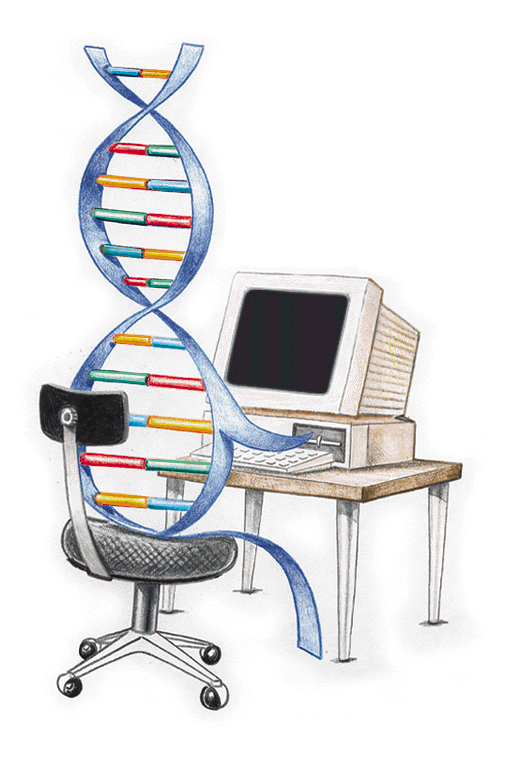

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

def clean_missing_values(df: pd.DataFrame, strategy: str = "mean", k: int = 5) -> pd.DataFrame:
    """
    Czyści NaN-y w dataframe.

    strategy:
      - "drop": usuwa wiersze z NaN
      - "mean": zastępuje średnią
      - "knn": używa KNNImputer z sklearn
    """
    if strategy == "drop":
        df_cleaned = df.dropna()
    elif strategy == "mean":
        df_cleaned = df.fillna(df.mean())
    elif strategy == "knn":
        imputer = KNNImputer(n_neighbors=k)
        df_cleaned = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    else:
        raise ValueError(f"Nieznana strategia: {strategy}")

    # Dla pewności – upewnij się, że wszystko jest OK
    assert not df_cleaned.isnull().any().any(), "Wciąż są NaNy po czyszczeniu!"
    return df_cleaned


In [ ]:
df = pd.read_csv("mitbih_train.csv", header=None)
X = df.iloc[:, :-1].copy()  # 187 punktów sygnału
y = df.iloc[:, -1]

X_clean = clean_missing_values(X, strategy="knn")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_clean)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=128, shuffle=True)


In [ ]:
class MLP_Simple_Autoencoder(nn.Module):
    def __init__(self, compressed_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(187, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, compressed_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(compressed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 187),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
class MLP_Expanded_Autoencoder(nn.Module):
    def __init__(self, compressed_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(187, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, compressed_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(compressed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 187),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
class MLP_Expanded_Autoencoder_V2(nn.Module):
    def __init__(self, compressed_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(187, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, compressed_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(compressed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 187),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train_autoencoder(model, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x_batch = batch[0]
            optimizer.zero_grad()
            x_recon = model(x_batch)
            loss = criterion(x_recon, x_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[{epoch+1}] Loss: {total_loss / len(loader):.6f}")
    return model

###  === 4. Eksperyment: kompresja vs jakość ===


In [ ]:
compression_levels = [8, 16, 32, 64]
reconstruction_errors = []

for dim in compression_levels:
    print(f"\n== Training with compressed_dim={dim} ==")
    model = MLP_Simple_Autoencoder(dim)
    model = train_autoencoder(model, epochs=10)
    with torch.no_grad():
        recon = model(X_tensor)
        mse = nn.functional.mse_loss(recon, X_tensor).item()
        reconstruction_errors.append(mse)


== Training with compressed_dim=8 ==
[1] Loss: 0.011723
[2] Loss: 0.004558
[3] Loss: 0.003801
[4] Loss: 0.003448
[5] Loss: 0.003219
[6] Loss: 0.003064
[7] Loss: 0.002942
[8] Loss: 0.002858
[9] Loss: 0.002759
[10] Loss: 0.002666

== Training with compressed_dim=16 ==
[1] Loss: 0.011431
[2] Loss: 0.004095
[3] Loss: 0.003050
[4] Loss: 0.002483
[5] Loss: 0.002141
[6] Loss: 0.001949
[7] Loss: 0.001811
[8] Loss: 0.001689
[9] Loss: 0.001611
[10] Loss: 0.001560

== Training with compressed_dim=32 ==
[1] Loss: 0.011362
[2] Loss: 0.003706
[3] Loss: 0.002689
[4] Loss: 0.002194
[5] Loss: 0.001845
[6] Loss: 0.001612
[7] Loss: 0.001456
[8] Loss: 0.001333
[9] Loss: 0.001234
[10] Loss: 0.001163

== Training with compressed_dim=64 ==
[1] Loss: 0.011122
[2] Loss: 0.003402
[3] Loss: 0.002419
[4] Loss: 0.001898
[5] Loss: 0.001557
[6] Loss: 0.001337
[7] Loss: 0.001189
[8] Loss: 0.001084
[9] Loss: 0.000998
[10] Loss: 0.000930


### === 5. Wykres jakości rekonstrukcji ===


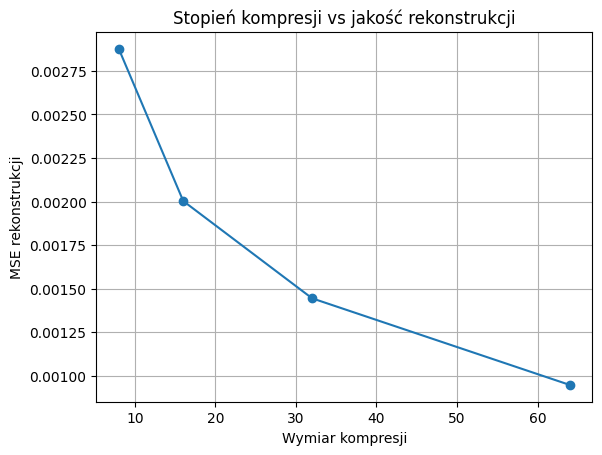

In [ ]:
plt.plot(compression_levels, reconstruction_errors, marker='o')
plt.xlabel("Wymiar kompresji")
plt.ylabel("MSE rekonstrukcji")
plt.title("Stopień kompresji vs jakość rekonstrukcji")
plt.grid(True)
plt.show()

In [ ]:
compression_levels = [8, 16, 32, 64]
reconstruction_errors = []

for dim in compression_levels:
    print(f"\n== Training with compressed_dim={dim} ==")
    model = MLP_Expanded_Autoencoder(dim)
    model = train_autoencoder(model, epochs=10)
    with torch.no_grad():
        recon = model(X_tensor)
        mse = nn.functional.mse_loss(recon, X_tensor).item()
        reconstruction_errors.append(mse)


== Training with compressed_dim=8 ==
[1] Loss: 0.013545
[2] Loss: 0.006285
[3] Loss: 0.004627
[4] Loss: 0.003951
[5] Loss: 0.003350
[6] Loss: 0.003072
[7] Loss: 0.002898
[8] Loss: 0.002712
[9] Loss: 0.002584
[10] Loss: 0.002509

== Training with compressed_dim=16 ==
[1] Loss: 0.013291
[2] Loss: 0.005435
[3] Loss: 0.003966
[4] Loss: 0.003336
[5] Loss: 0.002881
[6] Loss: 0.002672
[7] Loss: 0.002351
[8] Loss: 0.002176
[9] Loss: 0.002043
[10] Loss: 0.001911

== Training with compressed_dim=32 ==
[1] Loss: 0.012829
[2] Loss: 0.005252
[3] Loss: 0.003574
[4] Loss: 0.002889
[5] Loss: 0.002524
[6] Loss: 0.002266
[7] Loss: 0.002046
[8] Loss: 0.001887
[9] Loss: 0.001748
[10] Loss: 0.001661

== Training with compressed_dim=64 ==
[1] Loss: 0.013249
[2] Loss: 0.005615
[3] Loss: 0.003834
[4] Loss: 0.002995
[5] Loss: 0.002527
[6] Loss: 0.002176
[7] Loss: 0.001942
[8] Loss: 0.001784
[9] Loss: 0.001626
[10] Loss: 0.001534


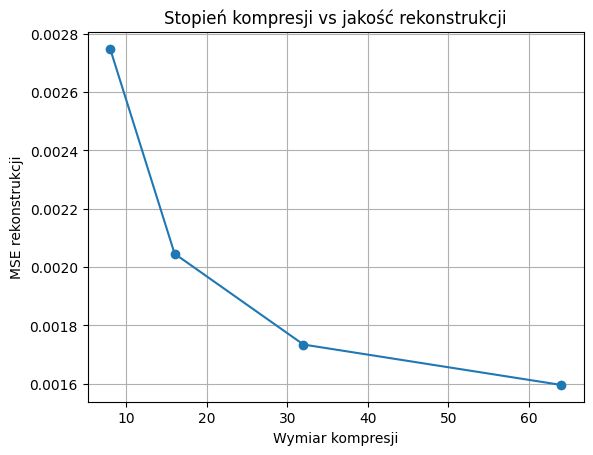

In [ ]:
plt.plot(compression_levels, reconstruction_errors, marker='o')
plt.xlabel("Wymiar kompresji")
plt.ylabel("MSE rekonstrukcji")
plt.title("Stopień kompresji vs jakość rekonstrukcji")
plt.grid(True)
plt.show()

In [ ]:
compression_levels = [8, 16, 32, 64]
reconstruction_errors = []

for dim in compression_levels:
    print(f"\n== Training with compressed_dim={dim} ==")
    model = MLP_Expanded_Autoencoder_V2(dim)
    model = train_autoencoder(model, epochs=10)
    with torch.no_grad():
        recon = model(X_tensor)
        mse = nn.functional.mse_loss(recon, X_tensor).item()
        reconstruction_errors.append(mse)


== Training with compressed_dim=8 ==
[1] Loss: 0.013844
[2] Loss: 0.006865
[3] Loss: 0.004867
[4] Loss: 0.004087
[5] Loss: 0.003586
[6] Loss: 0.003127
[7] Loss: 0.002803
[8] Loss: 0.002510
[9] Loss: 0.002318
[10] Loss: 0.002163

== Training with compressed_dim=16 ==
[1] Loss: 0.014112
[2] Loss: 0.007123
[3] Loss: 0.004896
[4] Loss: 0.003760
[5] Loss: 0.003085
[6] Loss: 0.002694
[7] Loss: 0.002432
[8] Loss: 0.002256
[9] Loss: 0.002039
[10] Loss: 0.001905

== Training with compressed_dim=32 ==
[1] Loss: 0.014926
[2] Loss: 0.006772
[3] Loss: 0.004431
[4] Loss: 0.003631
[5] Loss: 0.002973
[6] Loss: 0.002620
[7] Loss: 0.002342
[8] Loss: 0.002142
[9] Loss: 0.001946
[10] Loss: 0.001846

== Training with compressed_dim=64 ==
[1] Loss: 0.014231
[2] Loss: 0.006685
[3] Loss: 0.004494
[4] Loss: 0.003593
[5] Loss: 0.002896
[6] Loss: 0.002451
[7] Loss: 0.002176
[8] Loss: 0.002037
[9] Loss: 0.001863
[10] Loss: 0.001749


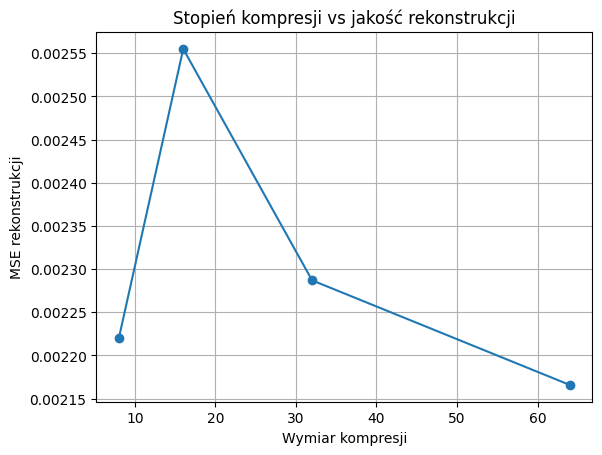

In [ ]:
plt.plot(compression_levels, reconstruction_errors, marker='o')
plt.xlabel("Wymiar kompresji")
plt.ylabel("MSE rekonstrukcji")
plt.title("Stopień kompresji vs jakość rekonstrukcji")
plt.grid(True)
plt.show()